## Bike Sharing Demand Model Training RF_SVR_SGDGBR

In [1]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt 
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA

C:\Users\Tingting Qi\Anaconda3\envs\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load Data  

In [4]:
#load data
train_df = pd.read_csv("train.csv")


# convert datetime column into multiple columns (year/month/day/hour/weekday)
dt_tr = pd.to_datetime(train_df["datetime"]) # convert string to datetime type
train_df["year"] = dt_tr.map(lambda x: x.year) 
train_df["month"] = dt_tr.map(lambda x: x.month)
train_df["day"] = dt_tr.map(lambda x: x.day)
train_df["hour"] = dt_tr.map(lambda x: x.hour)
train_df["weekday"] = dt_tr.map(lambda x: x.weekday())


train_df.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


In [2]:

test_df = pd.read_csv('test.csv')

# convert datetime column into multiple columns (year/month/day/hour/weekday)
dt_ts = pd.to_datetime(test_df["datetime"]) # convert string to datetime type
test_df["year"] = dt_ts.map(lambda x: x.year) 
test_df["month"] = dt_ts.map(lambda x: x.month)
test_df["day"] = dt_ts.map(lambda x: x.day)
test_df["hour"] = dt_ts.map(lambda x: x.hour)
test_df["weekday"] = dt_ts.map(lambda x: x.weekday())


test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,3


### Feature Engineering

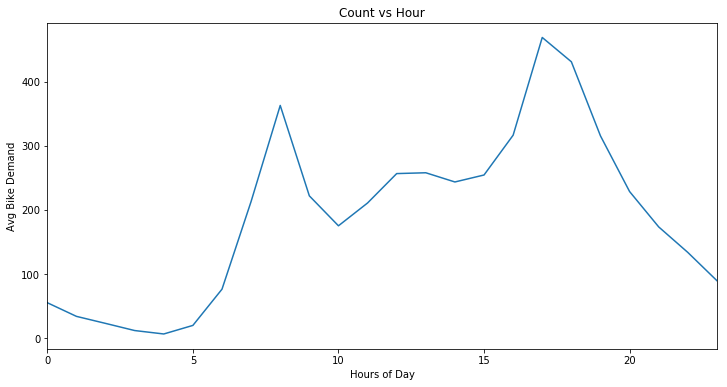

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday,peak_hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1,5,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2,5,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3,5,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4,5,0
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,1,5,5,0
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,2011,1,1,6,5,0
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,2011,1,1,7,5,1
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,2011,1,1,8,5,1
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14,2011,1,1,9,5,1


In [5]:
#exploratory analys on count vs hour 

fig,axes = plt.subplots(figsize = (12, 6))
hour_df = train_df.groupby(["hour"]).agg("mean")["count"]  
hour_df.plot(kind="line", ax=axes, title="Bike Rental by hour") 
plt.title('Count vs Hour')
axes.set_xlabel('Hours of Day')
axes.set_ylabel('Avg Bike Demand')
plt.show()

# add peakhour indicator (7 to 9 am & 5 to 7 pm )

peak = pd.Series(train_df['hour'])
train_df['peak_hour'] = peak.isin([7, 8, 9, 17, 18, 19]).astype(int)

test_df['peak_hour'] = peak.isin([7, 8, 9, 17, 18, 19]).astype(int)

train_df.head(10)

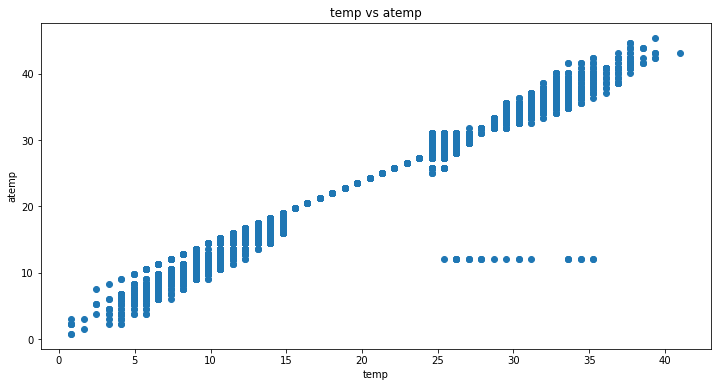

In [33]:
 
#exploratory analys on atemp vs temp
fig, axes = plt.subplots(figsize = (12, 6))
temperature = train_df[['temp', 'atemp']]
axes.scatter(temperature.temp, temperature.atemp)
plt.title('temp vs atemp')
axes.set_xlabel ('temp')
axes.set_ylabel('atemp')

 



C:\Users\Tingting Qi\Anaconda3\envs\python35\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Users\Tingting Qi\Anaconda3\envs\python35\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


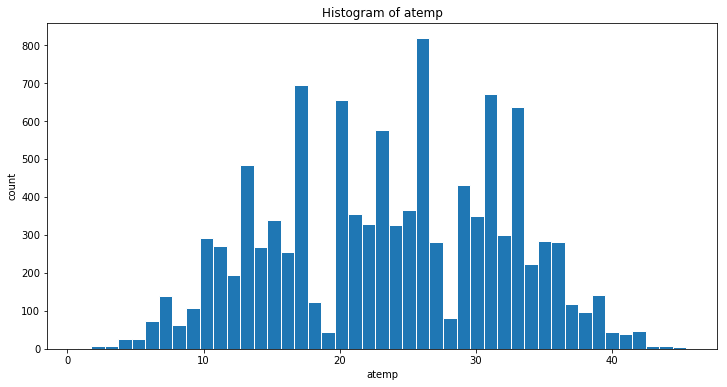

In [51]:
atemp_diff = round(train_df.atemp.max() - train_df.atemp.min(), 0)
 
fig, axes = plt.subplots(figsize = (12, 6))
axes.hist(train_df.atemp, bins = atemp_diff  , edgecolor = 'white')
plt.title('Histogram of atemp')
axes.set_xlabel ('atemp')
axes.set_ylabel('count')

In [17]:
#feature selection
#remove temp, but keep atemp
#remove season, but keep month
#remove workingday but keep day of week
#remove casual, registered
#remove year 
train_feature = train_df.drop(['temp', 'season', 'workingday', 'datetime', 'casual', 'registered', 'year', 'count'], axis = 1)
train_feature.head()

,holiday,weather,atemp,humidity,windspeed,month,day,hour,weekday,peak_hour
0,0,1,14.395,81,0.0,1,1,0,5,0
1,0,1,13.635,80,0.0,1,1,1,5,0
2,0,1,13.635,80,0.0,1,1,2,5,0
3,0,1,14.395,75,0.0,1,1,3,5,0
4,0,1,14.395,75,0.0,1,1,4,5,0


In [18]:
test_feature = test_df.drop(['temp', 'season', 'workingday', 'datetime', 'year'], axis = 1)
test_feature.head()

,holiday,weather,atemp,humidity,windspeed,month,day,hour,weekday,peak_hour
0,0,1,11.365,56,26.0027,1,20,0,3,0
1,0,1,13.635,56,0.0000,1,20,1,3,0
2,0,1,13.635,56,0.0000,1,20,2,3,0
3,0,1,12.880,56,11.0014,1,20,3,3,0
4,0,1,12.880,56,11.0014,1,20,4,3,0


In [20]:
 
#hot-encode categorical data

enc = preprocessing.OneHotEncoder()
 
encoded = enc.fit_transform(train_feature[['holiday', 'weather','month', 'day', 'hour', 'weekday', 'peak_hour']]).toarray()

#standardscaler numberic data
scaled = preprocessing.scale(train_feature[['atemp', 'humidity', 'windspeed']].values) 
 
trans_feature = np.concatenate([encoded, scaled], axis =1)

features = ['holiday', 'weather','month', 'day', 'hour', 'weekday', 'peak_hour', 'atemp', 'humidity', 'windspeed']

print ("encoded categorical data",'\n', encoded, np.shape(encoded), '\n') 
print ("scaled numeric data", '\n', scaled, np.shape(scaled), '\n')
print ("transformed data", '\n', trans_feature, np.shape(trans_feature), '\n')
print ("selected features: ", '\n', features)

encoded categorical data 
 [[ 1.  0.  1. ...,  0.  1.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 ..., 
 [ 1.  0.  1. ...,  0.  1.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]
 [ 1.  0.  1. ...,  0.  1.  0.]] (10886, 70) 

scaled numeric data 
 [[-1.09273697  0.99321305 -1.56775367]
 [-1.18242083  0.94124921 -1.56775367]
 [-1.18242083  0.94124921 -1.56775367]
 ..., 
 [-0.91395927 -0.04606385  0.26970368]
 [-0.73518157 -0.04606385 -0.83244247]
 [-0.82486544  0.21375537 -0.46560752]] (10886, 3) 

transformed data 
 [[ 1.          0.          1.         ..., -1.09273697  0.99321305
  -1.56775367]
 [ 1.          0.          1.         ..., -1.18242083  0.94124921
  -1.56775367]
 [ 1.          0.          1.         ..., -1.18242083  0.94124921
  -1.56775367]
 ..., 
 [ 1.          0.          1.         ..., -0.91395927 -0.04606385
   0.26970368]
 [ 1.          0.          1.         ..., -0.73518157 -0.04606385
  -0.83244247]
 [ 1.          0.          1.         ..., -0.

### Model Trainning

In [161]:
target = train_df['count']
#split train/test
train_data, test_data, train_target, test_target = train_test_split (trans_feature, target, test_size = 0.34, random_state = 200)

print ("train_data", train_data.shape,'\n', train_data, '\n')
print ('test_data', test_data.shape, '\n', test_data)


 

train_data (7184, 73) 
 [[ 1.          0.          1.         ..., -0.37762618  0.00589999
   0.5142603 ]
 [ 1.          0.          1.         ...,  1.7677062   0.42161076
   0.02432639]
 [ 1.          0.          1.         ..., -0.19884848 -0.92944922
   0.02432639]
 ..., 
 [ 1.          0.          1.         ...,  0.87381771 -0.04606385
  -1.56775367]
 [ 1.          0.          0.         ..., -1.62907006 -0.77355769
   0.02432639]
 [ 1.          0.          1.         ...,  0.87381771 -0.04606385
   0.26970368]] 

test_data (3702, 73) 
 [[ 1.          0.          1.         ..., -0.28853234  0.4735746
  -0.22023024]
 [ 1.          0.          0.         ..., -0.73518157 -0.61766615
  -0.22023024]
 [ 1.          0.          1.         ...,  0.87381771 -1.08534076
   1.37184982]
 ..., 
 [ 1.          0.          1.         ..., -2.70173625 -1.44908768
   0.75963759]
 [ 1.          0.          1.         ..., -0.91395927 -1.18926845
   0.75963759]
 [ 1.          0.          1.      

In [184]:
#rmsle function
def cal_rmsle(y, y_hat):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_hat]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

cal_rmsle([1,2,3],[2,6,2])

0.56717915832655263

####  Random Forest Modelling

In [186]:
#building initial model
model_rf = RandomForestRegressor(n_estimators = 100, max_depth = 20, random_state =0)
model_rf.fit(train_data, train_target)

rmsle_rf = cal_rmsle(test_target, model_rf.predict(test_data))

print ("RMSLE: ", remsle_rf)

0.5503653287301955

In [226]:
#parameter selection for modelling

estimators  = [100, 200, 300, 400, 500]

depths = [5, 10, 15, 20, 25, 30]

for estimator in estimators:
    for depth in depths:
        model_rf= RandomForestRegressor(n_estimators = estimator, max_depth = depth, random_state = 0)
        model_rf.fit(train_data, train_target)
        scores = cross_val_score(model_rf, train_data, train_target, cv=10)
        print ("n_estimator =", estimator, ", max_depth =",  depth, ", Accuracy =", scores.mean(), '\n' )
        

n_estimator = 100 , max_depth = 5 , Accuracy = 0.602945900113 

n_estimator = 100 , max_depth = 10 , Accuracy = 0.764761357061 

n_estimator = 100 , max_depth = 15 , Accuracy = 0.808059564587 

n_estimator = 100 , max_depth = 20 , Accuracy = 0.823865514994 

n_estimator = 100 , max_depth = 25 , Accuracy = 0.827627795927 

n_estimator = 100 , max_depth = 30 , Accuracy = 0.827665460741 

n_estimator = 200 , max_depth = 5 , Accuracy = 0.603655406967 

n_estimator = 200 , max_depth = 10 , Accuracy = 0.766192270272 

n_estimator = 200 , max_depth = 15 , Accuracy = 0.809278735842 

n_estimator = 200 , max_depth = 20 , Accuracy = 0.825049188278 

n_estimator = 200 , max_depth = 25 , Accuracy = 0.828692238891 

n_estimator = 200 , max_depth = 30 , Accuracy = 0.829264587065 

n_estimator = 300 , max_depth = 5 , Accuracy = 0.604097326606 

n_estimator = 300 , max_depth = 10 , Accuracy = 0.767092453114 

n_estimator = 300 , max_depth = 15 , Accuracy = 0.809880453542 

n_estimator = 300 , max_dept

In [236]:
# Best parameters for random forest model 

model_rf_best = RandomForestRegressor(random_state = 0, max_depth = 30, n_estimators = 500)
model_rf_best.fit(train_data, train_target)
rmsle_rf_best = cal_rmsle(test_target, model_rf.predict(test_data))

print ("RMSLE of Random Forest: ", rmsle_rf_best, ", max_depth = 30", ", n_estimators = 500")

RMSLE of Random Forest:  0.530305490944 , max_depth = 30 , n_estimators = 500


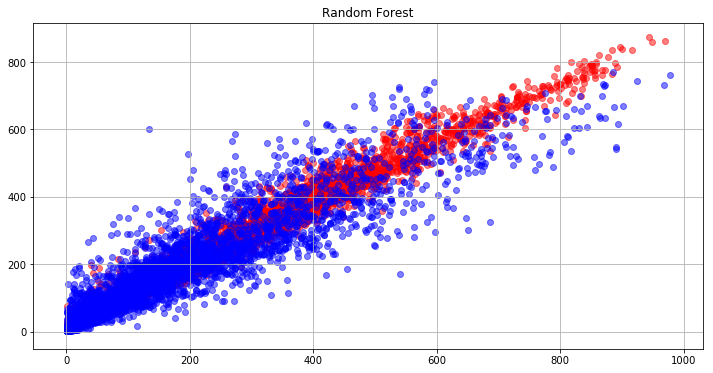

In [234]:
fig, axes = plt.subplots(figsize = (12, 6))
axes.grid(True)
axes.scatter(train_target, model_rf_best.predict(train_data), alpha = 0.5, color = 'red')
axes.scatter(test_target, model_rf_best.predict(test_data), alpha = 0.5, color = 'blue')
plt.title('Random Forest')
 
 

#### Gradien Boosting Modelling

In [246]:
#gbr with random selected parameters
model_gbr = GradientBoostingRegressor(n_estimators = 500, learning_rate = 0.8, max_depth = 30)
model_gbr.fit(train_data, train_target)

rmsle_gbr = cal_rmsle(test_target, model_gbr.predict(test_data))

 
print ("RMSLE of Gradient Boosting:", rmsle_gbr)


RMSLE of Gradient Boosting: 0.659473789423


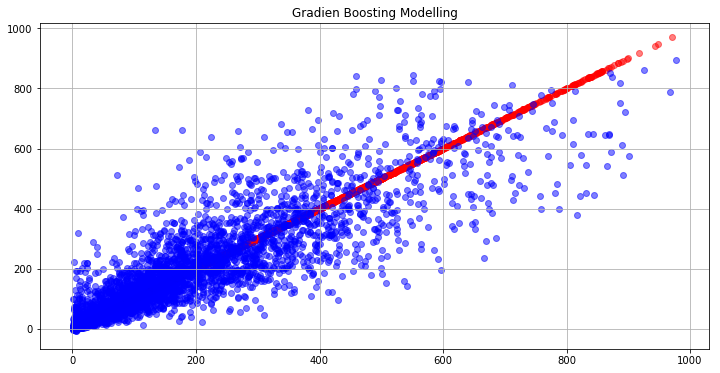

In [250]:
fig, axes = plt.subplots(figsize = (12, 6))
axes.grid(True)
axes.scatter(train_target, model_gbr.predict(train_data), alpha = 0.5, color = 'red')
axes.scatter(test_target, model_gbr.predict(test_data), alpha = 0.5, color = 'blue')
plt.title('Gradien Boosting Modelling')

#### Support Vector Regression Modelling

In [285]:
model_svr_rbf = SVR(C = 1e3, epsilon = 0.25, kernel = 'rbf', gamma = 0.1)
model_svr_rbf.fit(train_data,train_target) 
cal_rmsle(test_target, model_svr_rbf.predict(test_data))



C:\Users\Tingting Qi\Anaconda3\envs\python35\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in log


0.79309764017603268

In [284]:
gammas = [0.1, 0.05,  0.01]

for g in gammas:
    model_svg = SVR(C=1e3, epsilon = 0.25, kernel = "rbf", gamma = g)
    model_svg.fit(train_data, train_target)
    scores = cross_val_score(model_svg, train_data, train_target, cv = 10)
    print ("gamma = ", g, ", Accuracy =", scores.mean(), '\n')
    

gamma =  0.1 , Accuracy = 0.896505449342 

gamma =  0.05 , Accuracy = 0.8693239294 

gamma =  0.01 , Accuracy = 0.753315332354 



In [288]:
#best parameter for SVG
model_svr_best = SVR(C = 1e3, epsilon = 0.25, kernel = 'rbf', gamma = 0.1)
model_svr_best.fit(train_data,train_target) 
rmsle_svr_best = cal_rmsle(test_target, model_svr_best.predict(test_data))
print ("RMSLE of Support Vector Regression: ", rmsle_svr_best, ", gamma = 0.1")

RMSLE of Support Vector Regression:  0.793097640176 , gamma = 0.1


C:\Users\Tingting Qi\Anaconda3\envs\python35\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in log


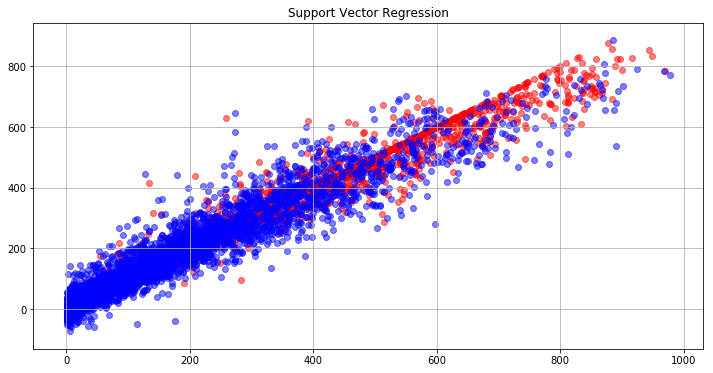

In [289]:
fig, axes = plt.subplots(figsize = (12, 6))
axes.grid(True)
axes.scatter(train_target, model_svr_best.predict(train_data), alpha = 0.5, color = 'red')
axes.scatter(test_target, model_svr_best.predict(test_data), alpha = 0.5, color = 'blue')
plt.title('Support Vector Regression')

#### PCA & Stochastic Gradient Descent Modeling

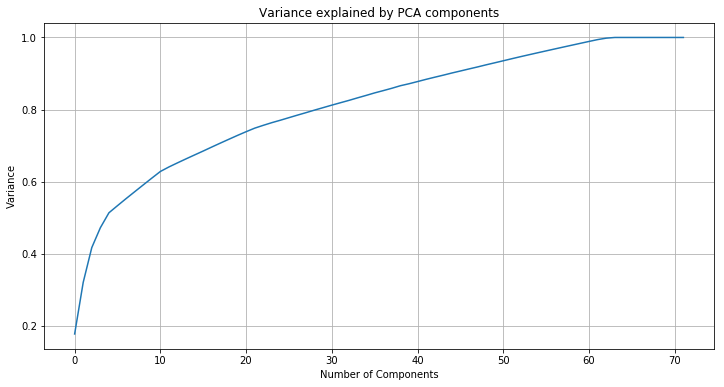

In [265]:
variance = []
#loop for add more features
for i in range(1, 73):
    pca = PCA(n_components = i)
    pca.fit(train_data)  #only standardized features
    variance.append(np.sum(pca.explained_variance_ratio_))

#plot variance
fig, axes = plt.subplots(figsize = (12, 6))
axes.grid(True)
axes.plot(variance)


#plot labelling
axes.set_ylabel('Variance')
axes.set_xlabel('Number of Components')
plt.title('Variance explained by PCA components')
 


In [280]:
#fit pca to train and test datasets
pca_tr = PCA(n_components = 65).fit_transform(train_data)
pca_ts = PCA(n_components=65).fit_transform(test_data)

#fit pca to SGD model
model_sgd_pca = linear_model.Lasso(alpha = 1, max_iter = 10000)
model_sgd_pca.fit(pca_tr, train_target)
rmsle_sgd_pca = cal_rmsle(test_target, model_sgd_pca.predict(pca_ts))

print ("RMSLE of Stochastic Gradient Descent Modeling with PCA: ", rmsle_sgd_pca )

RMSLE of Stochastic Gradient Descent Modeling with PCA:  1.18299202831


C:\Users\Tingting Qi\Anaconda3\envs\python35\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in log


In [283]:
alpha = [0.1, 0.3, 0.5, 0.7, 0.9]

for a in alpha:
    model_sgd_pca = linear_model.Lasso(alpha = a, max_iter =10000)
    model_sgd_pca.fit(pca_tr, train_target)
    scores = cross_val_score(model_sgd_pca, pca_tr, train_target, cv=10)
    print ("alpha =", a, ", Accuracy =", scores.mean(), '\n' )

alpha = 0.1 , Accuracy = 0.640260963875 

alpha = 0.3 , Accuracy = 0.638973642671 

alpha = 0.5 , Accuracy = 0.635740467478 

alpha = 0.7 , Accuracy = 0.631050954863 

alpha = 0.9 , Accuracy = 0.624954854578 



In [198]:
#simple sgd with original train & test datasets
model_sgd = linear_model.Lasso(alpha = 1, max_iter = 100000)
model_sgd.fit(train_data, train_target)
cal_rmsle(test_target, model_sgd.predict(test_data))  
    
    

C:\Users\Tingting Qi\Anaconda3\envs\python35\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in log


1.0444284422096122

In [277]:
#parameter selection

alpha = [0.1, 0.3, 0.5, 0.7, 0.9]

for a in alpha:
    model_sgd = linear_model.Lasso(alpha = a, max_iter =10000)
    model_sgd.fit(train_data, train_target)
    scores = cross_val_score(model_sgd, train_data, train_target, cv=10)
    print ("alpha =", a, ", Accuracy =", scores.mean(), '\n' )

alpha = 0.1 , Accuracy = 0.640353275534 

alpha = 0.3 , Accuracy = 0.638678797268 

alpha = 0.5 , Accuracy = 0.634762777056 

alpha = 0.7 , Accuracy = 0.628620258469 

alpha = 0.9 , Accuracy = 0.621094931844 



It seems the SGD model does not fit our dataet well.The adjustment of the alpha does not make any significant improvement.